# Analysis of collected ratings
to demonstrate the usage of the output format we use ratings from 
https://www.its.bldrdoc.gov/vqeg/projects/hdtv/hdtv.aspx
these ratings were not obtaines using AVRateNG, we converted the provided ratings for vqeghd1 test of the xls file to the avrateNG output format.
Because of this, the timestamps and playout ordering are not realistic and in this case generated or constant.

The `csv` file was generated using the `convert_ratings_to_csv.py`, its also possible to use the sqlite3 database directly, however using csv files is a better exchange format.


In [1]:
%matplotlib inline
import glob
import os
import json
from IPython.display import display as d

import pandas as pd
import numpy as np

# open the rating file
df = pd.read_csv("vqeg_hd.csv")

# check the input
d(df.head())

# remove columns that we don't need

df = df[df.columns.difference(["rating_type", "timestamp", "video_ID"])]
# check again
d(df.head())

# the videoname is now still a list, AvRateNG supports multiple videos as one stimulus, 
# that's why there is a list required, we remove the list

df["video_name"] = df["video_name"].apply(lambda x: eval(x)[0])  # we know that eval is evil
# check again
d(df.head())

# considering that our naming scheme of the presented stimuli has any meaning 
# we can now just extract, codec, conditions, source videos, etc.

df["src"] = df["video_name"].apply(lambda x: x.split("_")[1])
df["hrc"] = df["video_name"].apply(lambda x: x.split("_")[2].split(".")[0])

# check again
d(df.head())

,rating,rating_type,timestamp,user_ID,video_ID,video_name
0,5,radio,none,1,0,['vqeghd1_src01_hrc00.v1.avi']
1,4,radio,none,1,0,['vqeghd1_src03_hrc01.v1.avi']
2,3,radio,none,1,0,['vqeghd1_src06_hrc11.v1.avi']
3,2,radio,none,1,0,['vqeghd1_src09_hrc15.v1.avi']
4,5,radio,none,1,0,['vqeghd1_src14_hrc00.avi']


,rating,user_ID,video_name
0,5,1,['vqeghd1_src01_hrc00.v1.avi']
1,4,1,['vqeghd1_src03_hrc01.v1.avi']
2,3,1,['vqeghd1_src06_hrc11.v1.avi']
3,2,1,['vqeghd1_src09_hrc15.v1.avi']
4,5,1,['vqeghd1_src14_hrc00.avi']


,rating,user_ID,video_name
0,5,1,vqeghd1_src01_hrc00.v1.avi
1,4,1,vqeghd1_src03_hrc01.v1.avi
2,3,1,vqeghd1_src06_hrc11.v1.avi
3,2,1,vqeghd1_src09_hrc15.v1.avi
4,5,1,vqeghd1_src14_hrc00.avi


,rating,user_ID,video_name,src,hrc
0,5,1,vqeghd1_src01_hrc00.v1.avi,src01,hrc00
1,4,1,vqeghd1_src03_hrc01.v1.avi,src03,hrc01
2,3,1,vqeghd1_src06_hrc11.v1.avi,src06,hrc11
3,2,1,vqeghd1_src09_hrc15.v1.avi,src09,hrc15
4,5,1,vqeghd1_src14_hrc00.avi,src14,hrc00


# Outlier Detection, Calculation of MOS + CI Values
For a simple outlier detection, we first calculate the MOS values of each video




In [2]:

mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]
mos_per_videoname = mos_per_videoname.rename(columns={"rating": "mos"})
d(mos_per_videoname.head())

d_wo = pd.DataFrame()
# simple outlier "detection", better use the ITU-Rec XYZ
for userid, group in df.groupby(by="user_ID"):
    comp = pd.merge(group, mos_per_videoname, left_on="video_name", right_on="video_name")
    # calc correlation
    correlation_user_to_mos = comp[["rating", "mos"]].corr(method="pearson")["mos"][0]
    if correlation_user_to_mos < 0.8:
        print(f"outlier user {userid}")
    else:
        d_wo = d_wo.append(group, ignore_index=True)

    
df = d_wo
# calculate final mos values
mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]
mos_per_videoname = mos_per_videoname.rename(columns={"rating": "mos"})
d(mos_per_videoname.head())

# calculate ci values
import scipy.stats as st

def confidence(x):
    x = x["rating"]
    y = st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
    return  y[1] - y[0]


ci = d_wo[["video_name", "rating"]].groupby(by="video_name").apply(confidence).reset_index()
ci = ci.rename(columns={0: "ci"})

d(ci.head())

mos_ci_per_videoname = pd.merge(mos_per_videoname, ci, left_on="video_name", right_on="video_name")

d(mos_ci_per_videoname.head())

,video_name,mos
0,vqeghd1_src01_hrc00.v1.avi,4.583333
1,vqeghd1_src01_hrc01.v1.avi,1.916667
2,vqeghd1_src01_hrc02.v1.avi,1.791667
3,vqeghd1_src01_hrc03.v1.avi,1.250000
4,vqeghd1_src01_hrc04.v1.avi,1.083333


,video_name,mos
0,vqeghd1_src01_hrc00.v1.avi,4.583333
1,vqeghd1_src01_hrc01.v1.avi,1.916667
2,vqeghd1_src01_hrc02.v1.avi,1.791667
3,vqeghd1_src01_hrc03.v1.avi,1.250000
4,vqeghd1_src01_hrc04.v1.avi,1.083333


/home/sgoering/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/sgoering/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,video_name,ci
0,vqeghd1_src01_hrc00.v1.avi,0.425312
1,vqeghd1_src01_hrc01.v1.avi,0.654957
2,vqeghd1_src01_hrc02.v1.avi,0.608954
3,vqeghd1_src01_hrc03.v1.avi,0.448958
4,vqeghd1_src01_hrc04.v1.avi,0.344776


,video_name,mos,ci
0,vqeghd1_src01_hrc00.v1.avi,4.583333,0.425312
1,vqeghd1_src01_hrc01.v1.avi,1.916667,0.654957
2,vqeghd1_src01_hrc02.v1.avi,1.791667,0.608954
3,vqeghd1_src01_hrc03.v1.avi,1.250000,0.448958
4,vqeghd1_src01_hrc04.v1.avi,1.083333,0.344776


Text(0.5, 1.0, 'estimated a: 0.188')

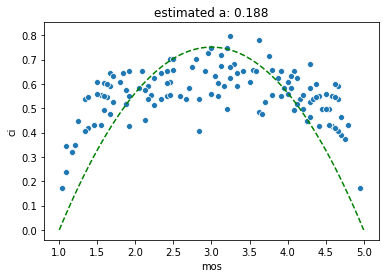

In [3]:
import seaborn as sns

mos_ci_per_videoname["src"] = mos_ci_per_videoname["video_name"].apply(lambda x: x.split("_")[1])
mos_ci_per_videoname["hrc"] = mos_ci_per_videoname["video_name"].apply(lambda x: x.split("_")[2].split(".")[0])

# draw a SOS plot
# read: http://materials.dagstuhl.de/files/15/15022/15022.TobiasHo%C3%9Ffeld1.Preprint.pdf
# for a more detailed description of SOS plots

ax = sns.scatterplot(x="mos", y="ci", data=mos_ci_per_videoname)

#, with the y=(x-1)*(x-5)* a interpolated function 

x_data = mos_ci_per_videoname["mos"].values
y_data = mos_ci_per_videoname["ci"].replace(np.NaN, 0).values

from scipy.optimize import curve_fit

def fitting_function(x, a):
    return (x - 1) * (x - 5) * (-a)

popt, pcov = curve_fit(fitting_function, x_data, y_data) 


x = np.linspace(1, 5, 100)
ax.plot(x, fitting_function(x, *popt), 'g--')
ax.set_title(f"estimated a: {popt[0].round(3)}")

# here an evaluation of the value for a is required, 
# for e.g. video tests this a value is typical in the range of [0.1,0.21], thus this value is fine

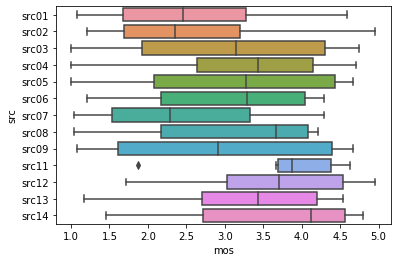

In [4]:
# a boxplot per SRC
sns.boxplot(x="mos", y="src", data=mos_ci_per_videoname)

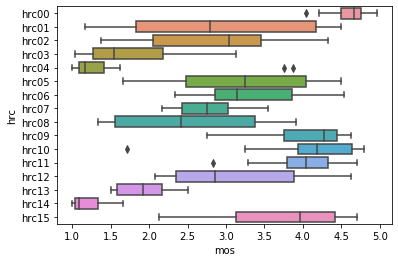

In [5]:
# a boxplot per HRC
sns.boxplot(x="mos", y="hrc", data=mos_ci_per_videoname)

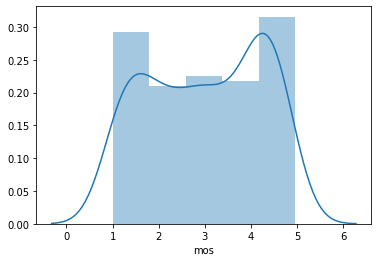

In [6]:
# mos distribution
sns.distplot(mos_ci_per_videoname["mos"])